In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.image import imread
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#### X Train
X_train_original = pd.read_csv("./DATA/X_train_update.csv" , sep = ',', header = 0, index_col = 0 )
# 84916 entries
print("X_train_original.info: ", X_train_original.info())
print("X_train_original.shape: ", X_train_original.shape)

# Y Train
y_train = pd.read_csv("./DATA/Y_train_CVw08PX.csv" , sep = ',', header = 0, index_col = 0 )
# 84916 entries
print("y_train.info: ", y_train.info())
print("y_train.shape: ", y_train.shape)

Product_catalog = pd.read_csv("./DATA/product_catalog.csv", sep = ';', header = 0)
# 27 entries
print("Product_catalog.info: ", Product_catalog.info())

###
dict_code_to_id={}
dict_id_to_code={}

list_tags = list(y_train['prdtypecode'].unique())

for i,tag in enumerate(list_tags):
    dict_code_to_id[tag] = i 
    dict_id_to_code[i]=tag
    
y_train['label'] = y_train['prdtypecode'].map(dict_code_to_id)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB
X_train_original.info:  None
X_train_original.shape:  (84916, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB
y_train.info:  None
y_train.shape:  (84916, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prdtypecode  27 non-null     

In [3]:
X_train_original['label'] = y_train['label']
X_train_original['label'] = X_train_original['label'].astype('string')

In [4]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
 1   label        84916 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


In [5]:
#######################################################################################################################################################
# (128,128), (256,256)
TARGET_SIZE = (256,256)
# 32, 64
BATCH_SIZE = 64
# 0.01, 0.001
LEARNING_RATE = 0.01

In [6]:

X_train_original['path'] = X_train_original.apply(lambda row: "./DATA/images/image_train/image_"+str(row['imageid'])+"_product_"+str(row['productid'])+".jpg", axis = 1)

In [7]:
# SPLIT TRAIN & TEST SETS
data_train_feats, data_test = train_test_split(
    X_train_original,                       # cleaned Pandas DataFrame
    test_size = 0.1,      # size of validation observations
    shuffle = True,             # shuffle observations (explicitly)
    stratify = X_train_original['label'],# preserve distribution of labels
    random_state = 123   # seed for shuffling observations
)

In [8]:
# SPLIT TRAIN & TEST SETS
data_train, data_val = train_test_split(
    data_train_feats,                       # cleaned Pandas DataFrame
    test_size = 0.2,      # size of validation observations
    shuffle = True,             # shuffle observations (explicitly)
    stratify = data_train_feats['label'],# preserve distribution of labels
    random_state = 1235   # seed for shuffling observations
)

In [9]:
# TRAINING GENERATOR
# Configure ImageDataGenerator
img_gen_train = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    # data augmentation
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 1.1,
    horizontal_flip = True
)
# Generate DataFrameIterator
data_flow_train = img_gen_train.flow_from_dataframe(
    dataframe = data_train,	  # use training observations
    target_size = TARGET_SIZE, # default, good enough
    shuffle = True,           # shuffle observations (explicitly)
    seed = 1222,          # /!\ for reproductibility /!\
    x_col = 'path',     	  # column containing path to image
    y_col = 'label',       # column containing label
    class_mode = 'sparse',    # classes are not one-hot encoded => sparse
    batch_size = BATCH_SIZE     # /!\ batch size to be used during training /!\
)

# VALIDATION GENERATOR
# Configure ImageDataGenerator
img_gen_val = ImageDataGenerator(
    preprocessing_function = preprocess_input	# /!\ must match model /!\
)
# Generate DataFrameIterator
data_flow_val = img_gen_val.flow_from_dataframe(
    dataframe = data_val,     # use validation observations
    target_size = TARGET_SIZE, # default, good enough
    shuffle = False,		  # /!\ shuffling this changes labels encoding /!\
    x_col = 'path',     	  # column containing path to image
    y_col = 'label',       # column containing label
    class_mode = 'sparse',    # classes are not one-hot encoded sparse
    batch_size = BATCH_SIZE     # /!\ batch size to be used during training /!\
)


Found 61139 validated image filenames belonging to 27 classes.
Found 15285 validated image filenames belonging to 27 classes.


In [10]:
# TEST GENERATOR
# Configure ImageDataGenerator
img_gen_test = ImageDataGenerator(
    preprocessing_function = preprocess_input	# /!\ must match model /!\
)
# Generate DataFrameIterator
data_flow_test = img_gen_test.flow_from_dataframe(
    dataframe = data_test,     # use validation observations
    target_size = TARGET_SIZE, # default, good enough
    shuffle = False,		  # /!\ shuffling this changes labels encoding /!\
    x_col = 'path',     	  # column containing path to image
    y_col = 'label',       # column containing label
    class_mode = 'sparse',    # classes are not one-hot encoded
    batch_size = BATCH_SIZE     # /!\ batch size to be used during training /!\
)

Found 8492 validated image filenames belonging to 27 classes.


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

MODEL_BASE = './' + str(BATCH_SIZE) + '_' + str(LEARNING_RATE) + '_'
MODEL_JSON = ''
MODEL_H5 = ''

#################################################################################################
# ResNet50, VGG16, MobileNetV2

IMAGE_ALGO = 'MobileNetV2'
#IMAGE_ALGO = 'ResNet50'
#IMAGE_ALGO = 'VGG16'

# 1
if IMAGE_ALGO == 'ResNet50':
    # Chargement du modèle efficientNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

    MODEL_JSON = MODEL_BASE + 'classifierTranferLearningResNet50.json'
    MODEL_H5 = MODEL_BASE + 'classifierTranferLearningResNet50.h5'

    # Bloquage du blackbone
    for layer in base_model.layers:
        #print("layer.name: ", layer.name)
        layer.trainable = False

    base_model.summary()

# 2
if IMAGE_ALGO == 'VGG16':
    # Modèle VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

    MODEL_JSON = MODEL_BASE + 'classifierTranferLearningVGG16.json'
    MODEL_H5 = MODEL_BASE + 'classifierTranferLearningVGG16.h5'

    # Bloquage du blackbone
    for layer in base_model.layers:
        layer.trainable = False

    base_model.summary()

# 3
if IMAGE_ALGO == 'MobileNetV2':
    # Modèle MobileNetV2
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3))

    MODEL_JSON = MODEL_BASE + 'classifierTranferLearningMobileNet_V2.json'
    MODEL_H5 = MODEL_BASE + 'classifierTranferLearningMobileNet_V2.h5'

    # Bloquage du blackbone
    for layer in base_model.layers:
        layer.trainable = False

    base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [12]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Activation
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam

model = Sequential()

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(27),
    Activation('softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)             

In [13]:
model.compile(
    optimizer = Adam(LEARNING_RATE),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [14]:
from tensorflow.keras import callbacks

# Réduction automatique du taux d'apprentissage
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         patience=3,
                                         factor=0.01,
                                         min_lr=1e-9,  # expectedly never reached
                                         verbose=1,
                                         mode='min')

cb_stopping = callbacks.EarlyStopping( monitor = 'val_loss',         # most reliable criterion
                                        mode = 'min',
                                        patience = 3,                 # stagnation tolerance
                                        restore_best_weights = True,
                                        verbose = 1)

In [15]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(MODEL_BASE + 'classifierTranferLearningTEST.log', separator=',', append=False)

In [16]:
history = model.fit(
            x = data_flow_train,              # training generator
            epochs = 10,
            validation_data = data_flow_val,  # validation generator
            batch_size = None,                # specified by generators
            callbacks = [lr_plateau, cb_stopping, csv_logger]
        )

392/956 [===========>..................] - ETA: 33:34 - loss: 2.3879 - accuracy: 0.3274

KeyboardInterrupt: 

In [242]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

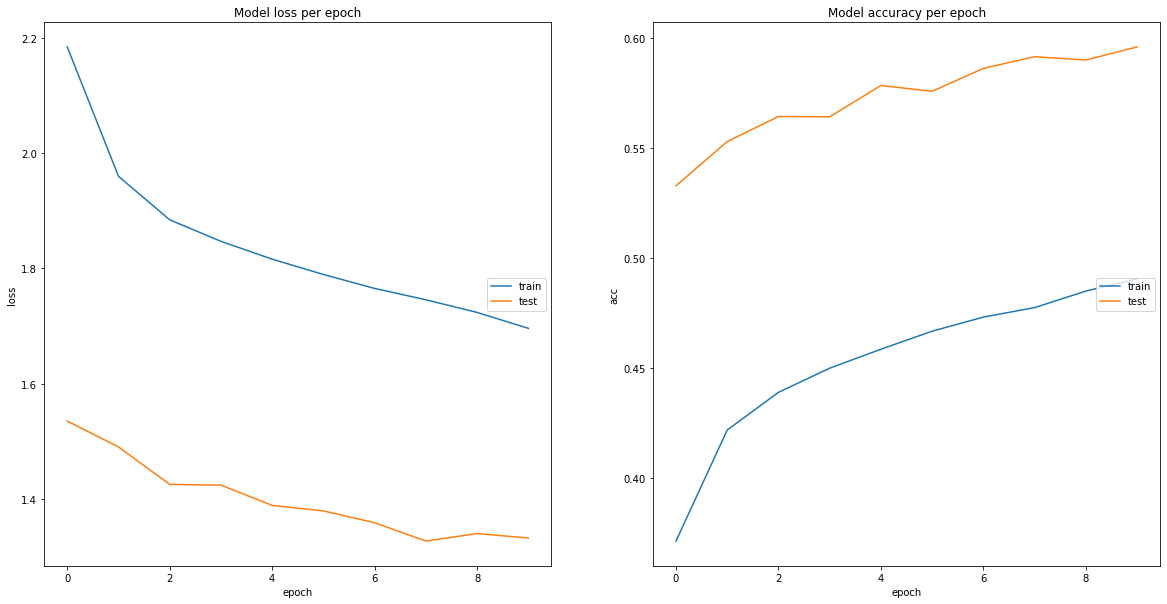

In [243]:
plt.figure(figsize = (20, 10))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

#plt.show()
#plt.savefig('./history_RestNet50.png')

In [244]:
#########
# Predictions
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_prob = model.predict(
    x = data_flow_test,    # use validation generator
    batch_size = None,    # specified by generator
    steps = None,         # specified by generator
    verbose = 1
)

classidx_pred = np.argmax(y_prob, axis=1)
classidx_true = np.array(data_flow_test.classes)

print('Accuracy :', accuracy_score(classidx_true, classidx_pred))

#y_pred = np.argmax(y_prob, axis=1)
#y_pred = tf.argmax(y_prob, axis=-1).numpy()

print('Confusion Matrix')
confusion_matrix_ = confusion_matrix(classidx_true, classidx_pred)
print(confusion_matrix_)

plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix_, annot=True)

ValueError: in user code:

    File "/Users/olivierdouangvichith/opt/anaconda3/envs/python38/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/Users/olivierdouangvichith/opt/anaconda3/envs/python38/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/olivierdouangvichith/opt/anaconda3/envs/python38/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/olivierdouangvichith/opt/anaconda3/envs/python38/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/Users/olivierdouangvichith/opt/anaconda3/envs/python38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/olivierdouangvichith/opt/anaconda3/envs/python38/lib/python3.8/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_2" (type Sequential).
    
    Input 0 of layer "rnn" is incompatible with the layer: expected ndim=3, found ndim=5. Full shape received: (None, None, None, None, 300)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, None, None, None), dtype=float32)
      • training=False
      • mask=None


In [122]:
from sklearn import metrics

print(metrics.classification_report(classidx_true, classidx_pred))

              precision    recall  f1-score   support

           0       0.45      0.41      0.43       312
           1       0.54      0.77      0.63       476
           2       0.68      0.55      0.61       478
           3       0.57      0.72      0.63       267
           4       0.84      0.83      0.83      1021
           5       0.46      0.21      0.29        76
           6       0.52      0.81      0.64       505
           7       0.76      0.49      0.60       142
           8       0.74      0.93      0.82       395
           9       0.53      0.56      0.54       499
          10       0.54      0.34      0.42       251
          11       0.52      0.72      0.61        83
          12       0.58      0.23      0.33       168
          13       0.59      0.38      0.47       324
          14       0.44      0.45      0.45       249
          15       0.55      0.46      0.50        83
          16       0.55      0.37      0.44        87
          17       0.56    

In [ ]:
metrics.f1_score(classidx_true, classidx_pred, average='weighted')

In [123]:
# Save Model
model_json = model.to_json()

with open(MODEL_JSON, "w") as json_file:
    json_file.write(model_json)

model.save_weights(MODEL_H5, save_format='h5')

/Users/olivierdouangvichith/opt/anaconda3/envs/python38/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [259]:
#######################################################################################################################################
# Load model
from tensorflow import keras
from keras.models import model_from_json

with open(MODEL_JSON, 'r') as fx:
    model_json_string = fx.read()

reconstructed_model_image = model_from_json(model_json_string)
reconstructed_model_image.load_weights(MODEL_H5)

In [260]:
MODEL_H5

'./64_0.001_classifierTranferLearningResNet50.h5'

In [16]:
######################################################################################################################################
######################################################################################################################################

In [261]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

reconstructed_y_prob = reconstructed_model_image.predict(
    x = data_flow_test,    # use validation generator
    batch_size = None,    # specified by generator
    steps = None,         # specified by generator
    verbose = 1
)

133/133 [==============================] - 379s 3s/step


In [262]:
y_prob_image = reconstructed_y_prob

In [355]:
dict_img_classes={'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26}

def get_class_num_from_img_idx(int_index):
    for str_key, int_val in dict_img_classes.items():
        if int_index == int_val:
            real_class = str_key
    return int(real_class)

In [356]:
tmp_matrix=np.zeros(y_prob_image.shape)
for ligne in range(y_prob_image.shape[0]):
    for colonne in range(y_prob_image.shape[1]):
        true_ind=get_class_num_from_img_idx(colonne)
        tmp_matrix[ligne][true_ind]=y_prob_image[ligne][colonne]

In [357]:
tmp_matrix

array([[2.21587819e-04, 1.65085009e-06, 1.27383828e-01, ...,
        2.16105916e-02, 3.92659742e-04, 1.39212608e-03],
       [2.35747226e-04, 2.06621771e-04, 2.16323929e-03, ...,
        3.38488072e-02, 3.38329737e-05, 2.14147391e-07],
       [8.18033994e-04, 2.18547299e-04, 1.19567174e-03, ...,
        3.47797573e-03, 2.19312757e-02, 6.88507874e-03],
       ...,
       [8.89788316e-06, 2.71085037e-06, 4.18704795e-03, ...,
        9.31525882e-03, 4.84760618e-03, 9.60888938e-05],
       [2.66275265e-06, 6.35381880e-08, 7.74604175e-03, ...,
        1.98984578e-01, 3.56588826e-05, 2.39079352e-03],
       [1.26105151e-03, 1.01520447e-03, 2.11763382e-03, ...,
        2.38835424e-01, 4.21197008e-04, 3.06689879e-04]])

In [358]:
reconstructed_y_prob = tmp_matrix

In [167]:
reconstructed_classidx_pred = np.argmax(reconstructed_y_prob, axis=1)
reconstructed_classidx_true = np.array(data_flow_test.classes)

accuracy = accuracy_score(reconstructed_classidx_true, reconstructed_classidx_pred)
print('Reconstructed Accuracy :', accuracy)

Reconstructed Accuracy : 0.5984455958549223


In [168]:
from sklearn import metrics
f1_score = metrics.f1_score(reconstructed_classidx_true, reconstructed_classidx_pred, average='weighted')
print('Reconstructed f1_score :', f1_score)

Reconstructed f1_score : 0.5956233534338919


Reconstructed Confusion Matrix


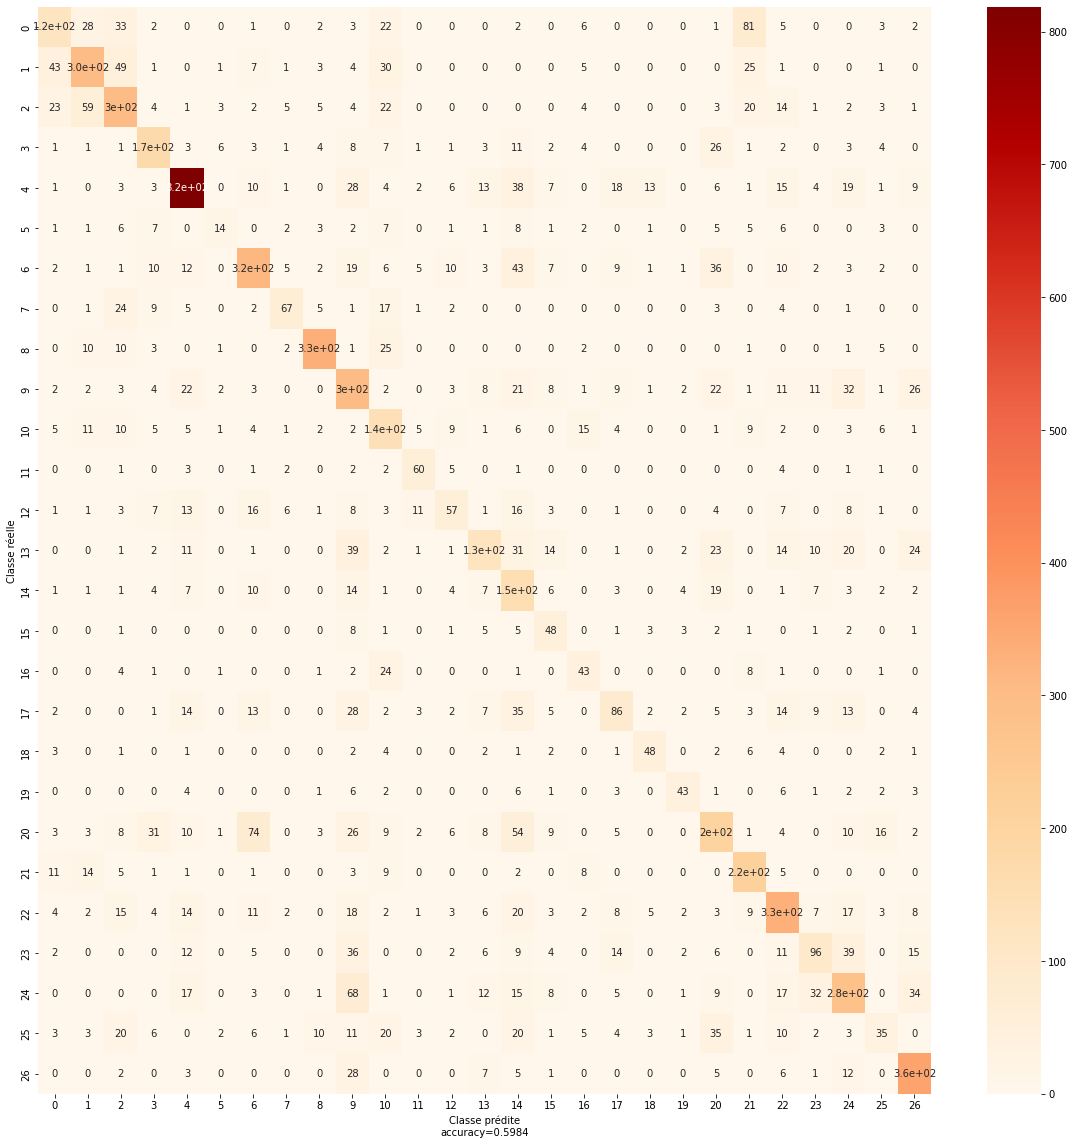

In [38]:
print('Reconstructed Confusion Matrix')

reconstructed_confusion_matrix_ = confusion_matrix(reconstructed_classidx_true, reconstructed_classidx_pred)

plt.figure(figsize=(20,20))
sns.heatmap(reconstructed_confusion_matrix_, annot=True, cmap="OrRd")

plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite\naccuracy={:0.4f}'.format(accuracy))

#plt.savefig('./matrice_confusion_RestNet50.png')